In [3]:
%pylab inline --no-import-all
import george
from george.kernels import MyDijetKernelSimp


import math
import time
import numpy as np
import scipy.stats as ss
import scipy.special as ssp
import scipy.optimize as op
from iminuit import Minuit

#import ROOT as r
#from rootpy.plotting import Hist, Hist2D, Legend, Canvas
#import rootpy.plotting.root2matplotlib as rplt

Populating the interactive namespace from numpy and matplotlib


### Load data set

In [4]:
xvalO = np.load("newoutputs/xvalO.npy")
yvalO = np.load("newoutputs/yvalO.npy")
xerrO = np.load("newoutputs/xerrO.npy")
xlowO = np.load("newoutputs/xlowO.npy")
xval = np.load("newoutputs/xval.npy")
yval = np.load("newoutputs/yval.npy")
xerr = np.load("newoutputs/xerr.npy")
smoothParams = np.load("newoutputs/smooth3parameters.npy")

xvalO2D = xvalO.reshape(-1,1)
yvalO2D = yvalO.reshape(-1,1)

### Function to draw correlation matrix, log of covaraince matrix, and covariance matrix. Draw correlation and covariance matrix as a function of mjj

In [80]:
def plot_cov(X, C, K, stationary=True):
    K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    m = ax1.imshow(C, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax1.set_title("Correlation Matrix")
    ax1.set_xlabel("X")
    ax1.set_ylabel("X")

    ax2 = fig.add_subplot(132)
    m = ax2.imshow(np.log(K), cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax2.set_title("Log(Covariance Matrix)")
    ax2.set_xlabel("X")
    ax2.set_ylabel("X")
    
    ax3 = fig.add_subplot(133)
    m = ax3.imshow(K, cmap="inferno",
                   interpolation='none',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    plt.colorbar(m);
    ax3.set_title("Covariance Matrix")
    ax3.set_xlabel("X")
    ax3.set_ylabel("X")
    
    fig = plt.figure(figsize=(13,5))
    ax = fig.add_subplot(111)
    if not stationary:
        ax.plot(x, np.diag(K), "k", lw=2, alpha=0.8)
        ax.set_title("The Diagonal of K")
        ax.set_ylabel("k(x,x)")
        ax.set_xscale('log')
        ax.set_yscale('log')
    else:
        ax.plot(x, K[:,0], "k", lw=2, alpha=0.8)
        ax.set_title("K as a function of x - x'")
        ax.set_ylabel("k(x,x')")
    ax.set_xlabel("X")

def plot_cor(X, C, stationary=True):
    #K = K #+ 1e-8*np.eye(X.shape[0])
    x = X.flatten()
    fig = plt.figure(figsize=(6,5))
    m = plt.imshow(C, cmap="bwr",
                   interpolation='none',
                   #vmin=-1, vmax=1,
                   aspect='auto',
                   extent=(np.min(X), np.max(X), np.max(X), np.min(X)));
    cbar = plt.colorbar(m)
    m.set_clim(vmin=-1, vmax=1)
    cbar.ax.tick_params(labelsize=20) 
    plt.title("Correlation Matrix", fontsize=20)
    plt.xlabel("Mass [TeV]", fontsize=20)
    plt.ylabel("Mass [TeV]", fontsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.tick_params(axis='x', labelsize=20)
    labels = ["2","3","4","5","6","7"]
    plt.xticks([2000, 3000, 4000, 5000, 6000, 7000], labels)
    plt.yticks([2000, 3000, 4000, 5000, 6000, 7000], labels)
    
def plot_individualCov(C, K):
    fig = plt.figure(figsize=(14,5))
    ax1 = fig.add_subplot(131)
    for i in range(len(K[1])):
        ax1.plot(xvalO,(K[i,:]))
    ax1.semilogy()
    ax1.set_title("Covariance vs mjj")
    
    ax2 = fig.add_subplot(132)
    #ax2.semilogy()
    for i in range(len(C[1])):
        plt.plot(xvalO,C[i,:])
    ax2.set_title("Correlation vs mjj")
    
    ax3 = fig.add_subplot(133)
    ax3.plot(xvalO,(K[5,:]), c='r', label="Covariance for bin 5")
    ax3.plot(xvalO,(K[40,:]), c='g', label="Covariance for bin 40")
    ax3.plot(xvalO,(K[75,:]),c='b', label = "Covariance for bin 75")
    ax3.legend()
    ax3.semilogy()

### Function to calculate z values and chi2

In [6]:
def calcSignificance(Data, Bkg):
    pvals = []
    zvals = []
    chi2 = 0
    for i, nD in enumerate(Data):
        nB = Bkg[i]
        if nD != 0:
            if nB > nD:
                pval = 1.-ssp.gammainc(nD+1.,nB)
            else:
                pval = ssp.gammainc(nD,nB)
            prob = 1.-2.*pval
            if prob > -1 and prob < 1:
                zval = math.sqrt(2.)*ssp.erfinv(prob)
            else:
                zval = np.inf
            if zval > 100: zval = 20
            if zval < 0: zval = 0
            if (nD < nB): zval = -zval
        else: zval = 0
            
        zvals.append(zval)
        chi2 += ((nD - nB) ** 2 / abs(nB)) 
    return zvals, chi2

### Function to draw fit overlaid on data on top panel, residuals on bottom panel

In [7]:
def makePrettyPlots(xs, ys, bkgs, title, col = 'g', ymax = 2e5):
    f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(12,12), gridspec_kw = {'height_ratios':[3, 1]})
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    bkgPlot, =ax1.plot(xs, bkgs, color=col, linewidth=3.0, label="bkg only")
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])
  
    #bin by bin significance    
    zvals, chi2 = calcSignificance(ys, bkgs)
    print "chi2", chi2
    h1 = Hist(xlowO,markersize=0)
    for x in range(len(zvals)):
        if zvals[x] == np.inf or zvals[x] == -np.inf: h1[x] = 20
        else: h1[x] = zvals[x]  
    
    h1.fillstyle = 'solid'
    if col == 'g':
         h1.fillcolor = 'green'
    elif col == 'b':
         h1.fillcolor = 'blue'
    elif col == 'r':
         h1.fillcolor = 'red'
    else:
        h1.fillcolor = 'black'
    h1.linecolor = 'black'
    h1.linewidth = 1
    h1.Draw("histX0")
    rplt.bar(h1, xerr=None, yerr=None)
    ax2.axhline(0, color='black', lw=1)
    ax2.tick_params(axis='x', labelsize=20)
    ax2.tick_params(axis='y', labelsize=20)
    ax2.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)
    ax2.set_ylabel('Significance', fontsize=20)
    ax2.set_xscale('log')
    ax2.set_xlim([1000, 7500])
    ax2.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax2.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax2.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax2.set_xticklabels(labels)
    ax2.set_ylim([-5, 5])
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()



### Draw multiple fits over data

In [8]:
def makePrettyPlots_bkgFits(xs, ys, bkgFits, title, ymax = 2e5):
    f, ax1 = plt.subplots(1, sharex=True, figsize=(12,12))
    f.suptitle(title, fontsize=30)
    dataPlot = ax1.errorbar(xs, ys, marker='o', ls='None', yerr = np.sqrt(ys), c='black', markersize=10, label="data+signal")
    for ik, bkg in enumerate(bkgFits):
        if ik == 0:
            bkgPlot, =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0, label="3 param only fit")
        else:
            bkgPlot =ax1.plot(xs, bkg, color="b", alpha=0.3, linewidth=1.0)
    ax1.legend()
    ax1.set_ylabel('Events', fontsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_yscale('log', nonposy="clip")
    ax1.set_xscale('log')
    ax1.set_xlim([1000, 7500])
    ax1.set_ylim([0.01, ymax])


    ax1.tick_params(axis='x', labelsize=20)
    ax1.tick_params(axis='y', labelsize=20)
    ax1.set_xlabel(r"$m_{jj}$ [TeV]", fontsize=30)

    ax1.set_xlim([1000, 7500])
    ax1.set_xticks([1000, 2000, 3000, 4000, 5000, 6000, 7000])
    ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    minor_ticks = np.arange(1000, 7500, 100)
    ax1.set_xticks(minor_ticks, minor=True)  
    labels = ["1","2","3","4","5","6","7"]
    ax1.set_xticklabels(labels)
    
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)    
    plt.show()

### 3 parameter fit function

In [9]:
def model_3param(t, params, xErr=xerr): 
    p0, p1, p2 = params
    sqrts = 13000.
    return (p0 * ((1.-t/sqrts)**p1) * (t/sqrts)**(p2))*(xErr)  

### Poisson likelihood

In [10]:
def simpleLogPoisson(x, par):
    if x < 0: 
        return np.inf
    elif (x == 0): return -1.*par
    else:
        lnpoisson = x*np.log(par)-par-ssp.gammaln(x+1.)
        return lnpoisson

### Minuit minimization of 3 parameter fit function
* Poisson likelihood function for 3 parameter fit function
* Minuit minimize log likelihood for 3 parameter fit fucntion

In [11]:
class logLike_3ff_minuit:
    def __init__(self, x, y, xe):
        self.x = x
        self.y = y
        self.xe = xe
    def __call__(self, p0, p1, p2):
        params = p0, p1, p2
        bkgFunc = model_3param(self.x, params, self.xe)       
        logL = 0
        for ibin in range(len(self.y)):
            data = self.y[ibin]
            bkg = bkgFunc[ibin]
            logL += -simpleLogPoisson(data, bkg)
        try:
            logL
            return logL
        except:
            return np.inf
        
def fit_3ff_minuit(num,lnprob, Print = True):
    minLLH = np.inf
    best_fit_params = (0., 0., 0.)
    for i in range(num):
        init0 = np.random.random() * 1.
        init1 = np.random.random() * 8.
        init2 = np.random.random() * 6.
        m = Minuit(lnprob, throw_nan = False, pedantic = False, print_level = 0,
                  p0 = init0, p1 = init1, p2 = init2,
                  error_p0 = 1e-2, error_p1 = 1e-1, error_p2 = 1e-1, 
                  limit_p0 = (0, 100.), limit_p1 = (-100., 100.), limit_p2 = (-100., 100.))
        m.migrad()
        if m.fval < minLLH:
            minLLH = m.fval
            best_fit_params = m.args 
    if Print:
        print "min LL",minLLH
        print "best fit vals", best_fit_params
    return minLLH, best_fit_params

### Extend bins to lower values for convolution

In [12]:
xvalO_low = np.array([794., 820.5,847.5, 875., 903., 931.5, 961.,991.,1021.5, 1052.5, 1084.0])
xerrO_low = np.array([26., 27., 27., 28., 28., 29., 30., 30., 31.0,31.0, 32.0])
xlowO_low = np.array([781.0, 807.0, 834.0, 861.0, 889.0, 917.0, 946.0, 976.0, 1006.0, 1037.0, 1068.0])
nx = np.append(xvalO_low, xvalO)
nxe = np.append(xerrO_low, xerrO)
nxl = np.append(xlowO_low, xlowO)


### smearing width

In [73]:
zs=np.arange(nxl[0], nxl[-1], 1)
steps = 10.*np.random.randn(50)+100.
#steps = 100.*np.random.randn(50)+100.
xs=nx
modelMatrix_width=np.zeros([len(steps), xs.size])
for bi, b in enumerate(steps):
    print bi, b
    newycounts=np.zeros(len(xs))
    for xi, x in enumerate(xs):
        for zi, z in enumerate(zs):
            zer= 1.
            pz=model_3param(z,smoothParams,zer)
            gaus = ss.norm.pdf(x, z, b)
            newycounts[xi]+=pz*gaus*nxe[xi] 
    modelMatrix_width[bi,:]= newycounts

0 97.5841307324
1 94.1775062955
2 90.9256047204
3 90.0813065217
4 109.203054322
5 108.548896997
6 98.5538948065
7 103.888293302
8 91.5095187155
9 107.947893565
10 84.6320839558
11 79.4630720758
12 88.7601121224
13 95.1108274683
14 95.5469083706
15 109.382493132
16 117.015768179
17 105.975163777
18 70.8268407103
19 105.964520441
20 92.904266417
21 114.685234448
22 104.638394452
23 113.489287353
24 97.044890891
25 111.664254445
26 81.1395068821
27 98.5934399088
28 92.7213667289
29 95.0398344059
30 88.6072942242
31 108.536121309
32 106.986374835
33 97.7127038875
34 99.69603159
35 96.6714949883
36 100.42342752
37 102.409808956
38 98.6203795628
39 99.2758812404
40 106.973740056
41 94.3602629894
42 90.5083715972
43 99.5031812953
44 88.1538241257
45 108.871452182
46 107.009879777
47 116.541246214
48 94.7977814733
49 91.9781245545


In [42]:
covMat_width = np.cov(modelMatrix_width[:,11:].T)
corMat_width = np.corrcoef(modelMatrix_width[:,11:].T)

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/matplotlib/scale.py:101: RuntimeWarning: invalid value encountered in less_equal
  a[a <= 0.0] = 1e-300


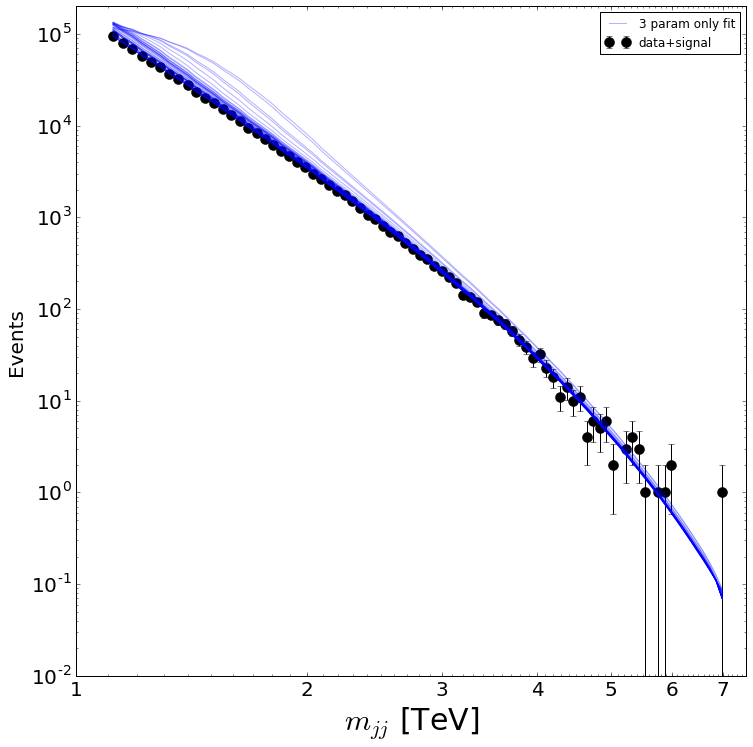

In [28]:
makePrettyPlots_bkgFits(xvalO, yvalO, (modelMatrix_width[:,11:]).tolist(), "", ymax = 2e5)

/Users/MeghanFrate/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in log


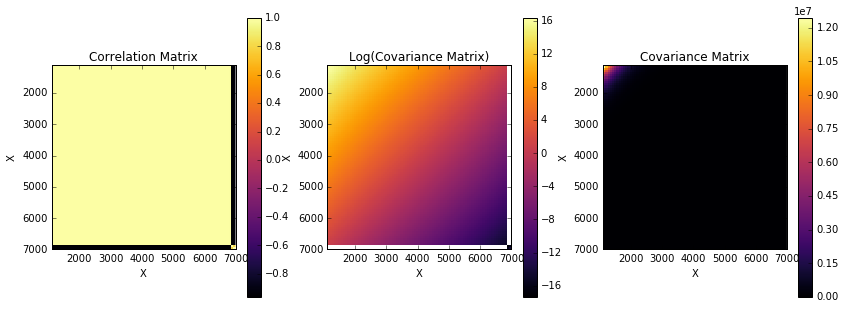

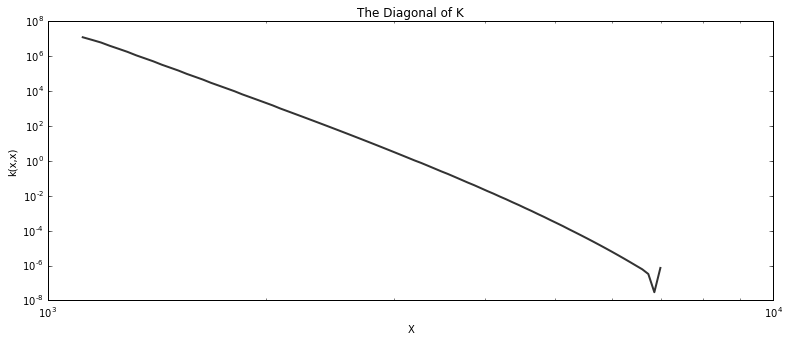

In [76]:
covMat_width = np.cov(modelMatrix_width[:,11:].T)
corMat_width = np.corrcoef(modelMatrix_width[:,11:].T)
plot_cov(xvalO.reshape(-1,1), corMat_width, covMat_width, False)

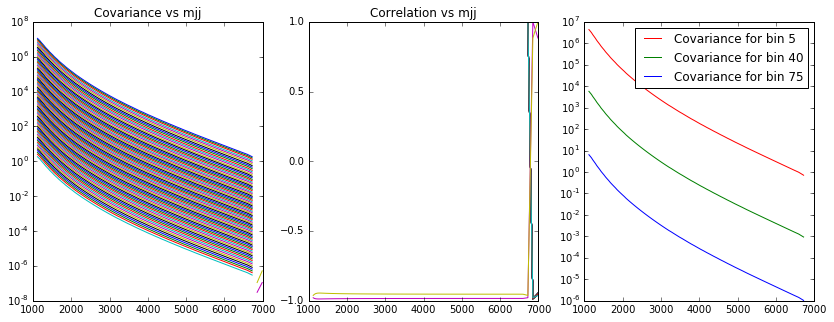

In [17]:
plot_individualCov(corMat_width, covMat_width)

### smearing mean

In [75]:
zs=np.arange(nxl[0], nxl[-1], 1)
#steps = 50.*np.random.randn(50)
steps = 10.*np.random.randn(50)
xs=nx
modelMatrix_mean=np.zeros([len(steps), xs.size])
for bi, b in enumerate(steps):
    print bi, b
    newycounts=np.zeros(len(xs))
    for xi, x in enumerate(xs):
        for zi, z in enumerate(zs):
            zer= 1.
            pz=model_3param(z,smoothParams,zer)
            gaus = ss.norm.pdf(x, z+b, 100.)
            newycounts[xi]+=pz*gaus*nxe[xi] 
    modelMatrix_mean[bi,:]= newycounts  

0 5.31243011162
1 1.01677977009
2 -2.64091497005
3 -7.50123936604
4 0.711617873252
5 -0.605548821538
6 1.96071947413
7 15.4610032597
8 24.3309768272
9 -1.26986149818
10 2.46079923436
11 -8.12797612612
12 1.4389033879
13 4.43128709898
14 14.3359081954
15 -2.47467558699
16 10.9120752366
17 -10.0529035568
18 7.86420598994
19 -0.687529568224
20 -4.18288298359
21 -15.2130938528
22 8.87990086036
23 2.23135760202
24 -15.9330930673
25 -11.7834455095
26 0.628223035184
27 5.41128505377
28 -3.34411119592
29 -8.55933670138
30 14.1797123563
31 -8.1409988262
32 -2.42847672221
33 -5.00383776715
34 0.546838963313
35 22.3600476954
36 4.05502399979
37 0.489538090212
38 3.88600399146
39 6.99219440692
40 -3.75039663471
41 8.78794352676
42 -11.2423688284
43 11.6308878778
44 -11.6096796224
45 3.56841499793
46 11.7899945039
47 -18.7945936296
48 -12.8488592109
49 -7.94684081657


In [32]:
covMat_mean = np.cov(modelMatrix_mean[:,11:].T)
corMat_mean = np.corrcoef(modelMatrix_mean[:,11:].T)

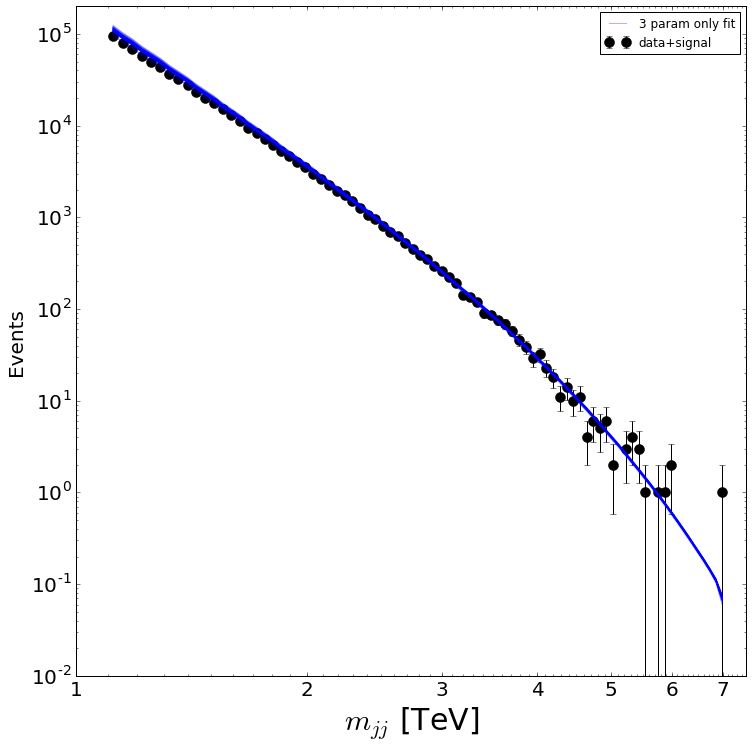

In [20]:
makePrettyPlots_bkgFits(nx[11:], yvalO, (modelMatrix_mean[:,11:]).tolist(), "", ymax = 2e5)

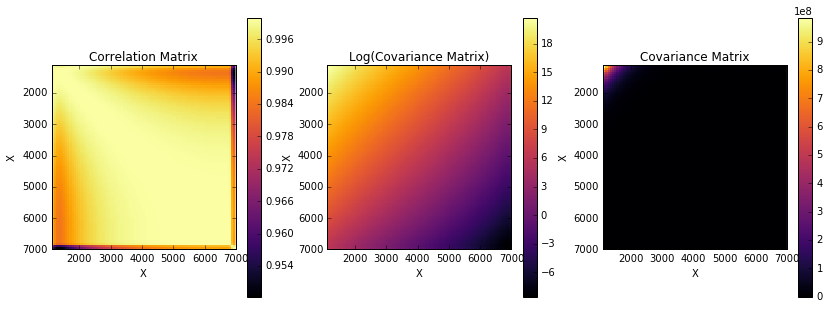

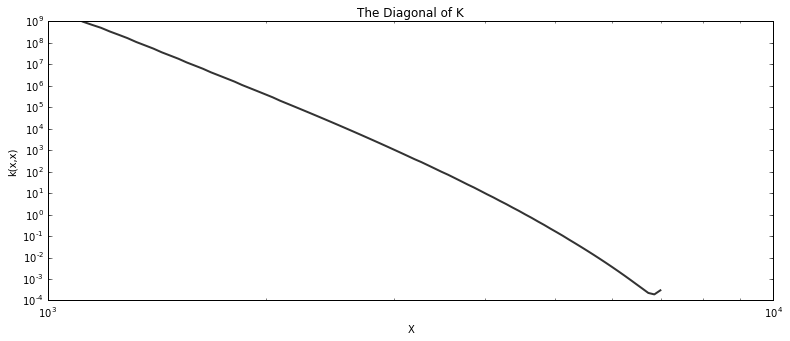

In [62]:
plot_cov(nx[11:].reshape(-1,1), corMat_mean, covMat_mean, False)

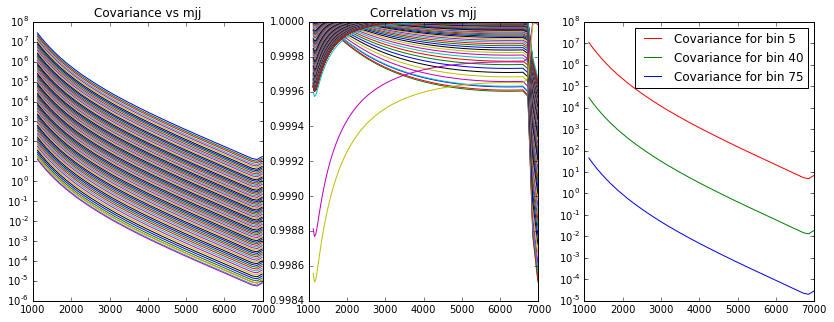

In [22]:
plot_individualCov(corMat_mean, covMat_mean)

In [77]:
combinedM = np.concatenate((modelMatrix_width[:,11:], modelMatrix_mean[:,11:]), axis=0)

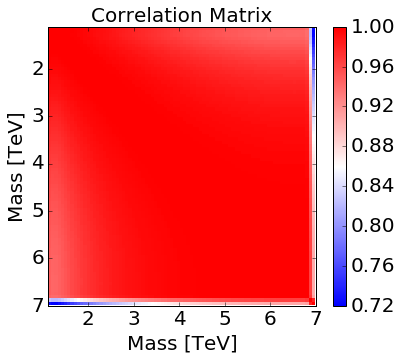

In [81]:
corM = np.corrcoef(combinedM.T)
plot_cor(nx[11:].reshape(-1,1), corM, False)